In [1]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import parsing
import helper

In [3]:
def is_trivial_filter(trivial_instances):
    return lambda row: not (row['network'],row['spec'],row['mirror']) in trivial_instances

# ACAS

Loading (and later discarding) trivial instances.
An instance is trivial if its midpoint already violates the property.

In [42]:
# Load trivial_acas.pkl
trivial_acas = pickle.load(open('trivial_acas.pkl', 'rb'))
# Load trivial_acas_focus.pkl
trivial_acas_focus = pickle.load(open('trivial_acas_focus.pkl', 'rb'))

In [43]:
trivial_acas[0]

('ACASXU_run2a_1_1_batch_2000', 'prop_1', 'prune-10')

In [44]:
results_full = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in [5, 10, 30]],
    "VeryDiff", "0.05", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/MILPEquiv-OneThread-{p}", f"prune-{p}") for p in [5, 10, 30]],
    "MILPEquiv", "0.05", parsing.parse_milpequiv),
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/NNEquiv-OneThread-{p}", f"prune-{p}") for p in [5, 10, 30]],
    "NNEquiv", "0.05", parsing.parse_nnequiv),
    
    pd.read_pickle("../benchmarks_abcrown/acas-prune_results.pkl"),
    pd.read_pickle("../benchmarks_abcrown/acas-prune_results_marabou.pkl")
])
results_focus = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/VeryDiff-OneThread-Focus-{p}-Combined", f"prune-{p}") for p in [5, 10, 30]],
    "VeryDiff", "0.05", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/NeuroDiff-OneThread-{p}", f"prune-{p}") for p in [5, 10, 30]],
    "NeuroDiff", "0.05", parsing.parse_neurodiff)])

In [45]:
results_full

status       time                                      init_bounds_0  \
0      safe   0.835715  [-1244.6605536944933, -1438.4960949161803, -15...   
1    unsafe   0.011990  [-4234.879911149251, -2068.93809805044, -2004....   
2      safe   1.406862  [-2569.945466783139, -3008.131487883151, -3125...   
3      safe   0.307850  [-372.8930815848452, -418.5824970866161, -545....   
4      safe  10.291921  [-6056.026710984801, -5880.608850747864, -6910...   
..      ...        ...                                                ...   
532    safe   0.923000                                                NaN   
533  unsafe   1.062000                                                NaN   
534  unsafe   2.235000                                                NaN   
535  unsafe   0.935000                                                NaN   
536    safe   2.187000                                                NaN   

                                         init_bounds_1   splits  \
0    [1278.022424897925, 1505.838466024031, 1519.25...    766.0   
1    [4267.342116373154, 2068.4993722993795, 2001.2...      2.0   
2    [2692.715151777735, 3252.043294125815, 3064.85...    795.0   
3    [356.6650150227942, 419.25910185286665, 552.13...    219.0   
4    [6464.349815295138, 6115.792124439177, 7229.38...  12290.0   
..                                                 ...      ...   
532                                                NaN      NaN   
533                                                NaN      NaN   
534                                                NaN      NaN   
535                                                NaN      NaN   
536                                                NaN      NaN   

     instable_generators                      network     spec    solver  \
0                  242.0  ACASXU_run2a_1_1_batch_2000  prop_16  VeryDiff   
1                  212.0  ACASXU_run2a_4_5_batch_2000  prop_10  VeryDiff   
2                  240.0  ACASXU_run2a_1_1_batch_2000   prop_1  VeryDiff   
3                  255.0  ACASXU_run2a_1_2_batch_2000   prop_1  VeryDiff   
4                  258.0  ACASXU_run2a_1_3_batch_2000   prop_1  VeryDiff   
..                   ...                          ...      ...       ...   
532                  NaN  ACASXU_run2a_2_4_batch_2000   prop_3   Marabou   
533                  NaN  ACASXU_run2a_3_8_batch_2000   prop_3   Marabou   
534                  NaN  ACASXU_run2a_5_1_batch_2000  prop_14   Marabou   
535                  NaN  ACASXU_run2a_5_6_batch_2000   prop_3   Marabou   
536                  NaN  ACASXU_run2a_3_6_batch_2000   prop_3   Marabou   

    property    mirror  
0       0.05   prune-5  
1       0.05   prune-5  
2       0.05   prune-5  
3       0.05   prune-5  
4       0.05   prune-5  
..       ...       ...  
532      1.0   prune-5  
533      1.0  prune-10  
534      1.0   prune-5  
535      1.0  prune-30  
536      1.0  prune-30  

[2685 rows x 11 columns]

In [46]:
# Overriding wrong result for MILPEquiv
results_full.loc[(results_full['solver']=='MILPEquiv') & (results_full['spec']=='prop_4') & (results_full['network']=='ACASXU_run2a_2_6_batch_2000') & (results_full['mirror']=='prune-30'), 'status'] = 'unknown'

In [47]:
print("Instances in ACAS-Full:", len(results_full))
print("Instances in ACAS-Focus:", len(results_focus))

Instances in ACAS-Full: 2685
Instances in ACAS-Focus: 1074


In [48]:
# Filter out trivial instances
results_full = results_full[results_full.apply(is_trivial_filter(trivial_acas), axis=1)]

results_focus = results_focus[results_focus.apply(is_trivial_filter(trivial_acas_focus), axis=1)]

In [49]:
print("Instances in ACAS-Full:", len(results_full))
print("Instances in ACAS-Focus:", len(results_focus))

Instances in ACAS-Full: 1530
Instances in ACAS-Focus: 676


In [50]:
print("Number of NNs for ACAS-Full:")
print(len(results_full.groupby(['network']).size()))
print("Number of Properties for ACAS-Full:")
print(len(results_full.groupby(['network', 'spec', 'mirror']).size()))

print("Number of NNs for ACAS-Focus:")
print(len(results_focus.groupby(['network']).size()))
print("Number of Properties for ACAS-Focus:")
print(len(results_focus.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs for ACAS-Full:
45
Number of Properties for ACAS-Full:
306
Number of NNs for ACAS-Focus:
45
Number of Properties for ACAS-Focus:
338


In [51]:
results_full_acas = results_full.copy()

In [52]:
results_full = helper.compute_speedup(results_full, "VeryDiff", "MILPEquiv")
results_full = helper.compute_speedup(results_full, "VeryDiff", "NNEquiv")
results_full = helper.compute_speedup(results_full, "VeryDiff", "abCROWN")
results_full = helper.compute_speedup(results_full, "VeryDiff", "Marabou")

results_focus = helper.compute_speedup(results_focus, "VeryDiff", "NeuroDiff")

Baseline:  19
Variant:  303
Merged:  19
Baseline:  179
Variant:  303
Merged:  178
Baseline:  271
Variant:  303
Merged:  270
Baseline:  219
Variant:  303
Merged:  219
Baseline:  200
Variant:  330
Merged:  200


/home/samuel/Dokumente/Projects/NNV/NeuroDiff/repos/VeryDiffExperiments/analysis-new/helper.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["speedup"] = np.nan


In [53]:
import onnxruntime as ort
import numpy as np
# Load the model and create InferenceSession
model_path1 = "../benchmarks/acas-prune/nets/ACASXU_run2a_2_6_batch_2000.onnx"
model_path2 = "../benchmarks/acas-prune/nets_pruned/ACASXU_run2a_2_6_batch_2000_pruned30.onnx"
session1 = ort.InferenceSession(model_path1)
session2 = ort.InferenceSession(model_path2)
inputTensor = np.array([-0.303531156, -0.009549297000000002, 0.0, 0.5, 0.083333333],dtype=np.float32)
outputs1 = np.array(session1.run(None, {"X": inputTensor}))
outputs2 = np.array(session2.run(None, {"X": inputTensor}))
print(np.abs(outputs1-outputs2))

[[0.06937034 0.00145048 0.04244159 0.02094377 0.02094396]]


VeryDiff has a concrete counterexample --> mismatch is issue with MILPEquiv
```
[-0.303531156, -0.009549297000000002, 0.0, 0.5, 0.083333333]
```

In [54]:
results_full.loc[(results_full["solver"]=="MILPEquiv") & (results_full["mirror"]=="prune-30") & (results_full["spec"]=="prop_4") &(results_full["network"]=="ACASXU_run2a_2_6_batch_2000"),"status"] = "unknown"

In [55]:
results_full = helper.compute_speedup(results_full, "VeryDiff", "MILPEquiv")

Baseline:  19
Variant:  303
Merged:  19


In [56]:
table_1_1 = results_full.copy()
table_1_1["safe"] = table_1_1["status"]=="safe"
table_1_1["unsafe"] = table_1_1["status"]=="unsafe"
table_1_1["unknown"] = table_1_1["status"]=="unknown"
table_1_1 = table_1_1.groupby(["solver"]).agg({"safe": "sum", "unsafe": "sum", "speedup": ["median","max"]})
table_1_1

table_1_2 = results_focus.copy()
table_1_2["safe"] = table_1_2["status"]=="safe"
table_1_2["unsafe"] = table_1_2["status"]=="unsafe"
table_1_2["unknown"] = table_1_2["status"]=="unknown"
table_1_2 = table_1_2.groupby(["solver"]).agg({"safe": "sum", "unsafe":"sum", "speedup": ["median","max"]})

table_1_full_epsilon = pd.concat([table_1_1, table_1_2], keys=["Full", "Focus"]).copy()
table_1_full_epsilon["benchmark"] = "ACAS"
table_1_full_epsilon[[("benchmark",""),("safe","sum"),("unsafe","sum"),("speedup","median"),("speedup","max")]]

benchmark safe unsafe      speedup              
                           sum    sum       median           max
      solver                                                    
Full  MILPEquiv      ACAS   16      3  7224.811427  36296.977628
      Marabou        ACAS  110    109   141.254648  10070.463627
      NNEquiv        ACAS   37    142    37.315925   8091.161084
      VeryDiff       ACAS  150    153          NaN           NaN
      abCROWN        ACAS  121    150    15.385184   1954.116571
Focus NeuroDiff      ACAS  121     79    43.133306  16134.701061
      VeryDiff       ACAS  169    161          NaN           NaN

### Bound Improvement

In [29]:
results_focus_verydiff = results_focus[results_focus["solver"]=="VeryDiff"]
results_focus_neurodiff = results_focus[results_focus["solver"]=="NeuroDiff"]
results_focus_merged = pd.merge(results_focus_verydiff, results_focus_neurodiff, on=["network", "spec", "property", "mirror"], suffixes=("_verydiff", "_neurodiff"))

In [30]:
results_focus_merged["bound_improvement"] = results_focus_merged.apply(lambda row: (row["init_bounds_1_verydiff"]-row["init_bounds_0_verydiff"])/(row["init_bounds_1_neurodiff"]-row["init_bounds_0_neurodiff"]), axis=1)

In [31]:
bound_improvements = []
for x in results_focus_merged["bound_improvement"]:
    bound_improvements.extend(x.tolist())
bound_improvements = np.array(bound_improvements)

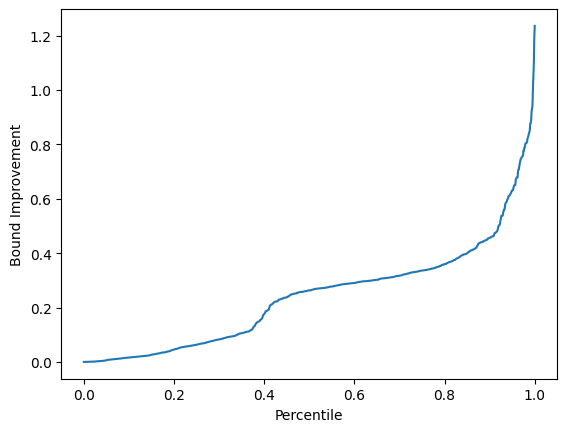

In [32]:
x = np.linspace(0,1,1000)
y = []
for i in x:
    y.append(np.percentile(bound_improvements, i*100))
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Percentile")
ax.set_ylabel("Bound Improvement")
plt.show()

# MNIST (VeriPrune)

In [57]:
# Load trivial_acas.pkl
trivial_acas = pickle.load(open('trivial_mnist.pkl', 'rb'))
# Load trivial_acas_focus.pkl
trivial_acas_focus = pickle.load(open('trivial_mnist_focus.pkl', 'rb'))

In [58]:
trivial_acas[0]

('mnist_relu_2_512', 'mnist_0_global_3', 'prune-5')

In [59]:
results_full = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/MILPEquiv-OneThread-{p}", f"prune-{p}") for p in [5]],
    "MILPEquiv", "1.0", parsing.parse_milpequiv),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/NNEquiv-OneThread-{p}", f"prune-{p}") for p in [5]],
    "NNEquiv", "1.0", parsing.parse_nnequiv),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in [5]],
    "VeryDiff", "1.0", parsing.parse_verydiff),
    pd.read_pickle("../benchmarks_abcrown/mnist-prune_results.pkl"),
    pd.read_pickle("../benchmarks_abcrown/mnist-prune_results_marabou.pkl")
])
results_focus = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/VeryDiff-OneThread-Focus-{p}-Combined", f"prune-{p}") for p in [5]],
    "VeryDiff", "1.0", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/NeuroDiff-OneThread-Focus-{p}", f"prune-{p}") for p in [5]],
    "NeuroDiff", "1.0", parsing.parse_neurodiff)])

In [60]:
print("Instances in MNIST-Full:", len(results_full))
print("Instances in MNIST-Focus:", len(results_focus))

Instances in MNIST-Full: 9101
Instances in MNIST-Focus: 4800


In [61]:
# Filter out trivial instances
results_full = results_full[results_full.apply(is_trivial_filter(trivial_acas), axis=1)]

results_focus = results_focus[results_focus.apply(is_trivial_filter(trivial_acas_focus), axis=1)]

In [71]:
print("Instances in MNIST-Full:", len(results_full))
print("Instances in MNIST-Focus:", len(results_focus))

Instances in MNIST-Full: 3148
Instances in MNIST-Focus: 2178


In [63]:
results_full.groupby(['network']).agg({"network":"first"})

network
network                           
mnist_relu_3_100  mnist_relu_3_100

In [64]:
print("Number of NNs for MNIST-Full:")
print(len(results_full.groupby(['network']).size()))
print("Number of Properties for MNIST-Full:")
print(len(results_full.groupby(['network', 'spec', 'mirror']).size()))

print("Number of NNs for MNIST-Focus:")
print(len(results_focus.groupby(['network']).size()))
print("Number of Properties for MNIST-Focus:")
print(len(results_focus.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs for MNIST-Full:
1
Number of Properties for MNIST-Full:
701
Number of NNs for MNIST-Focus:
3
Number of Properties for MNIST-Focus:
1089


In [65]:
results_full_mnist = results_full.copy()

In [66]:
# Overriding wrong results for Marabou (see details below)
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_85_global_6') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_49_global_5') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_44_global_6') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_66_global_4') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_85_global_5') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_44_global_5') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_54_global_5') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_61_global_4') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_49_global_3') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_81_global_4') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_88_global_6') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_49_global_4') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'
results_full.loc[(results_full['solver']=='Marabou') & (results_full['spec']=='mnist_31_global_3') & (results_full['network']=='mnist_relu_3_100') & (results_full['mirror']=='prune-5'), 'status'] = 'unknown'

In [67]:
results_full = helper.compute_speedup(results_full, "VeryDiff", "MILPEquiv")
#results_full = helper.compute_speedup(results_full, "VeryDiff", "MILPEquiv-BT")
results_full = helper.compute_speedup(results_full, "VeryDiff", "NNEquiv")
results_full = helper.compute_speedup(results_full, "VeryDiff", "abCROWN")
results_full = helper.compute_speedup(results_full, "VeryDiff", "Marabou")

results_focus = helper.compute_speedup(results_focus, "VeryDiff", "NeuroDiff")

Baseline:  35
Variant:  414
Merged:  22
Baseline:  103
Variant:  414
Merged:  61
Baseline:  286
Variant:  414
Merged:  215
Baseline:  34
Variant:  414
Merged:  12
Baseline:  458
Variant:  699
Merged:  450


**Counterexamples of Marabou:**
These show up if we omit the filtering code above; all manually checked.
In all cases the reported difference does not exceed 1.0/-1.0
- mnist_85_global_6 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_49_global_5 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_44_global_6 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_66_global_4 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_85_global_5 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_44_global_5 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_54_global_5 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_61_global_4 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_49_global_3 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_81_global_4 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_88_global_6 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_49_global_4 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)
- mnist_31_global_3 mnist_relu_3_100 prune-5 (unsafe vs safe): No violation beyond 1.0 (does not violate spec)

### Table

In [68]:
table_1_1 = results_full.copy()
table_1_1["safe"] = table_1_1["status"]=="safe"
table_1_1["unsafe"] = table_1_1["status"]=="unsafe"
table_1_1["unknown"] = table_1_1["status"]=="unknown"
table_1_1 = table_1_1.groupby(["solver"]).agg({"safe": "sum", "unsafe": "sum", "unknown": "sum", "speedup": ["median","max"]})
table_1_1

table_1_2 = results_focus.copy()
table_1_2["safe"] = table_1_2["status"]=="safe"
table_1_2["unsafe"] = table_1_2["status"]=="unsafe"
table_1_2["unknown"] = table_1_2["status"]=="unknown"
table_1_2 = table_1_2.groupby(["solver"]).agg({"safe": "sum", "unsafe": "sum", "unknown": "sum", "speedup": ["median","max"]})

table_1_full_mnist_veriprune = pd.concat([table_1_1, table_1_2], keys=["Full", "Focus"]).copy()
table_1_full_mnist_veriprune["benchmark"] = "MNIST"
table_1_full_mnist_veriprune[[("benchmark",""),("safe","sum"),("unsafe","sum"),("unknown","sum"),("speedup","median"),("speedup","max")]]

benchmark safe unsafe unknown     speedup             
                           sum    sum     sum      median          max
      solver                                                          
Full  MILPEquiv     MNIST    7     28     309  525.221575  1985.371080
      Marabou       MNIST   10     24     667  183.884891  1390.835053
      NNEquiv       MNIST    0    103     598   12.624262   166.189469
      VeryDiff      MNIST  352     62     287         NaN          NaN
      abCROWN       MNIST  175    110     415  516.891697  4220.817055
Focus NeuroDiff     MNIST  410     48     631    4.454416  1086.838414
      VeryDiff      MNIST  457    242     390         NaN          NaN

In [69]:
results_full[np.logical_and(results_full["solver"]=="abCROWN", np.logical_and(results_full["status"] != "unknown", np.logical_and(results_full["status"] != "safe", results_full["status"] != "unsafe")))]

status  time           network              spec   solver property  \
2137  error   0.0  mnist_relu_3_100  mnist_5_local_24  abCROWN      1.0   

       mirror init_bounds_0 init_bounds_1  splits  instable_generators  \
2137  prune-5           NaN           NaN     NaN                  NaN   

      speedup  
2137      NaN

### Radi

In [80]:
mnist_epsilon = results_full.copy()
mnist_epsilon["radius"] = mnist_epsilon["spec"].apply(lambda x: int(x.split("_")[-1]))
mnist_epsilon["prop_type"] = mnist_epsilon["radius"].apply(lambda x: "local" if x > 6 else "global")
mnist_epsilon = mnist_epsilon[mnist_epsilon["solver"] != "MILPEquiv"]

In [81]:
font = {'size'   : 20}

plt.rc('font', **font)

/tmp/ipykernel_132989/3114389138.py:16: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "global"].groupby(["solver"]):
/tmp/ipykernel_132989/3114389138.py:26: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "local"].groupby(["solver"]):


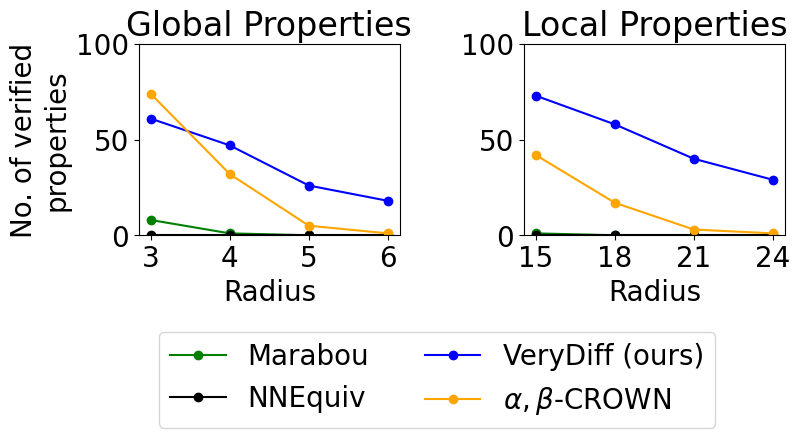

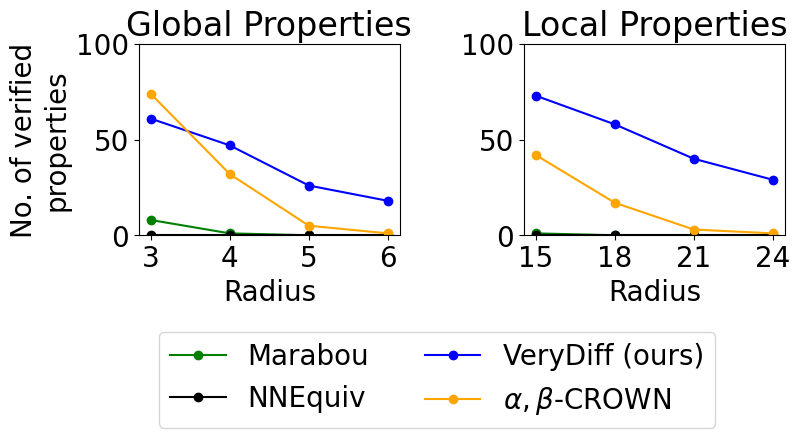

In [88]:
labels = {
    ("VeryDiff",): "VeryDiff (ours)",
    ("NNEquiv",): "NNEquiv",
    ("Marabou",): "Marabou",
    ("abCROWN",): "$\\alpha,\\beta$-CROWN",
}
colors = {
    ("VeryDiff",): "blue",
    ("NNEquiv",): "black",
    ("Marabou",): "green",
    ("abCROWN",): "orange"
}
mnist_epsilon["solved"] = (mnist_epsilon["status"] == "safe" ) #| (mnist_epsilon["status"] == "unsafe")
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()
for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "global"].groupby(["solver"]):
    res = solver_instances.groupby(["radius"]).agg({
        "solved": "sum"
    })
    ax[0].plot(res.index, res["solved"], label=labels[label], marker="o", color=colors[label])
ax[0].set_title("Global Properties")
ax[0].set_xlabel("Radius")
ax[0].set_ylabel("No. of verified\nproperties")
ax[0].set_xticks(range(3, 7))
ax[0].set_ylim(0,100)
for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "local"].groupby(["solver"]):
    res = solver_instances.groupby(["radius"]).agg({
        "solved": "sum"
    })
    ax[1].plot(res.index, res["solved"], marker="o", color=colors[label])
ax[1].set_title("Local Properties")
ax[1].set_xlabel("Radius")
ax[1].set_xticks([15,18,21,24])
ax[1].set_ylim(0,100)
fig.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),ncol=2)
fig


In [89]:
fig.savefig("epsilon_mnist_radius_comparison.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Bound Improvement

In [38]:
results_focus_verydiff = results_focus[results_focus["solver"]=="VeryDiff"]
results_focus_neurodiff = results_focus[results_focus["solver"]=="NeuroDiff"]
results_focus_merged = pd.merge(results_focus_verydiff, results_focus_neurodiff, on=["network", "spec", "property", "mirror"], suffixes=("_verydiff", "_neurodiff"))

In [42]:
results_focus_merged

status_verydiff  time_verydiff  \
0             unsafe      48.250776   
1            unknown     120.637606   
2               safe       0.223149   
3             unsafe       1.376413   
4             unsafe       0.072280   
...              ...            ...   
1084            safe       0.027656   
1085         unknown     120.405655   
1086            safe       0.300098   
1087          unsafe       0.564816   
1088            safe       0.129692   

                                 init_bounds_0_verydiff  \
0     [-21.725376528009946, -20.250346917967477, -14...   
1     [-10.952913870531896, -13.7107449178292, -17.9...   
2     [-0.1742119624610428, -0.36611383028877764, -0...   
3     [-81.33388727486718, -82.2670250698005, -93.67...   
4     [-15.693409296320493, -11.890511916352175, -11...   
...                                                 ...   
1084  [-0.3738312536369467, -0.5524995717566958, -0....   
1085  [-7.771822451756668, -5.352265848945671, -4.31...   
1086  [-0.18078122431541566, 0.0, -0.142473695778089...   
1087  [-4.98475156087124, -13.027325651152244, -12.9...   
1088  [-0.3815095786395224, 0.0, -0.508447673459687,...   

                                 init_bounds_1_verydiff  splits_verydiff  \
0     [24.009221932465493, 24.486457965229988, 22.16...           1313.0   
1     [8.495230253483657, 7.866257602727228, 2.98694...            144.0   
2     [0.11933591955379245, 0.12241978005489594, 0.0...              0.0   
3     [80.39153341747581, 82.2670250698005, 89.11271...              0.0   
4     [15.509186872796064, 20.55993372213524, 15.180...              0.0   
...                                                 ...              ...   
1084  [0.3738312536369468, 0.5524995717566958, 0.511...              0.0   
1085  [2.423218673001863, 2.882805521451867, 2.71604...            202.0   
1086  [0.054586629690837274, 0.0, 0.1424736957780898...              0.0   
1087  [6.989651509371585, 0.644019776390012, -0.3386...              0.0   
1088  [0.4523016624627827, 0.0, 0.6102609981062321, ...              0.0   

                network               spec solver_verydiff property   mirror  \
0      mnist_relu_2_512  mnist_38_local_24  VeryDiff-Focus      1.0  prune-5   
1      mnist_relu_2_512  mnist_50_global_5  VeryDiff-Focus      1.0  prune-5   
2      mnist_relu_3_100  mnist_50_global_5  VeryDiff-Focus      1.0  prune-5   
3     mnist_relu_4_1024   mnist_8_local_21  VeryDiff-Focus      1.0  prune-5   
4      mnist_relu_2_512  mnist_34_local_21  VeryDiff-Focus      1.0  prune-5   
...                 ...                ...             ...      ...      ...   
1084   mnist_relu_3_100  mnist_67_local_18  VeryDiff-Focus      1.0  prune-5   
1085   mnist_relu_2_512  mnist_61_global_4  VeryDiff-Focus      1.0  prune-5   
1086   mnist_relu_3_100  mnist_61_global_4  VeryDiff-Focus      1.0  prune-5   
1087   mnist_relu_2_512  mnist_55_global_4  VeryDiff-Focus      1.0  prune-5   
1088   mnist_relu_3_100  mnist_55_global_4  VeryDiff-Focus      1.0  prune-5   

      speedup_verydiff status_neurodiff  time_neurodiff  \
0                  NaN          unknown      120.008079   
1                  NaN          unknown      120.022463   
2                  NaN             safe        0.211439   
3                  NaN          unknown      120.016067   
4                  NaN          unknown      120.020807   
...                ...              ...             ...   
1084               NaN             safe        0.183524   
1085               NaN          unknown      120.014765   
1086               NaN             safe        0.206013   
1087               NaN          unknown      120.025760   
1088               NaN             safe        0.208428   

                                init_bounds_0_neurodiff  \
0     [-16.590352, -17.829199, -15.645242, -17.44365...   
1     [-5.62578, -3.448526, 0.188583, -2.351397, -3....   
2     [-0.109811, -0.086762, -0.062318, -0.095662, -...   
3     [-

In [39]:
results_focus_merged["bound_improvement"] = results_focus_merged.apply(lambda row: (row["init_bounds_1_verydiff"]-row["init_bounds_0_verydiff"])/(row["init_bounds_1_neurodiff"]-row["init_bounds_0_neurodiff"]), axis=1)

/tmp/ipykernel_383572/626838443.py:1: RuntimeWarning: invalid value encountered in divide
  results_focus_merged["bound_improvement"] = results_focus_merged.apply(lambda row: (row["init_bounds_1_verydiff"]-row["init_bounds_0_verydiff"])/(row["init_bounds_1_neurodiff"]-row["init_bounds_0_neurodiff"]), axis=1)


In [51]:
results_focus_merged["bad_case"] = results_focus_merged.apply(lambda row: np.any(row["bound_improvement"] >2), axis=1)

In [52]:
results_focus_merged[results_focus_merged["bad_case"]]

status_verydiff  time_verydiff  \
33              safe     115.245065   
212             safe       0.027684   
258          unknown     120.030892   
305          unknown     120.324942   
455          unknown     120.358603   
531             safe       0.169776   
824             safe       0.279834   
835             safe       0.150448   
873             safe       0.125032   
877             safe       0.151664   
1050            safe       0.106783   

                                 init_bounds_0_verydiff  \
33    [0.0, -0.4375699316043188, -0.9465118812872166...   
212   [0.0, -0.41618617206612296, -0.230310262192549...   
258   [0.0, -0.7249097771702232, -0.9690498982085942...   
305   [0.0, 0.0, -0.40783461562796175, 0.0, 0.250953...   
455   [0.0, 0.0, -1.369212850708864, -0.886232310454...   
531   [0.0, -0.3873810759914303, -0.2042864278202886...   
824   [0.0, 0.0, -0.6094308429412614, 0.152963916080...   
835   [0.09490008242767212, 0.0, 0.7805471025834513,...   
873   [0.0, -0.06130705309717163, -0.224115287122801...   
877   [0.0, -0.4155919586654123, -0.2482556655882083...   
1050  [0.0, -0.19326814819635074, -0.404486368532473...   

                                 init_bounds_1_verydiff  splits_verydiff  \
33    [0.0, 0.3834807509830054, 0.9465118812872166, ...          35670.0   
212   [0.0, 0.41618617206612296, 0.16519072768028478...              0.0   
258   [0.0, 0.7249097771702232, 0.13375378560711287,...            583.0   
305   [0.0, 0.0, 0.37611600990919347, 0.0, 1.0917823...            582.0   
455   [0.0, 0.0, 0.5163020462290229, 0.8862323104542...            514.0   
531   [0.0, 0.3873810759914303, 0.1638479752171259, ...              0.0   
824   [0.0, 0.0, 0.6094308429412614, 0.9959487836407...              0.0   
835   [0.7660943096093054, 0.0, 1.9311364443536188, ...              0.0   
873   [0.0, 0.4590657686603784, 0.15530682303041515,...              0.0   
877   [0.0, 0.41559195866541243, 0.3094769564906131,...              0.0   
1050  [0.0, 0.19326814819635074, 0.20407936947094474...              0.0   

               network               spec solver_verydiff property   mirror  \
33    mnist_relu_3_100  mnist_68_local_15  VeryDiff-Focus      1.0  prune-5   
212   mnist_relu_3_100  mnist_73_local_15  VeryDiff-Focus      1.0  prune-5   
258   mnist_relu_3_100  mnist_34_global_3  VeryDiff-Focus      1.0  prune-5   
305   mnist_relu_3_100  mnist_27_global_3  VeryDiff-Focus      1.0  prune-5   
455   mnist_relu_3_100   mnist_9_global_4  VeryDiff-Focus      1.0  prune-5   
531   mnist_relu_3_100  mnist_73_global_4  VeryDiff-Focus      1.0  prune-5   
824   mnist_relu_3_100  mnist_68_global_3  VeryDiff-Focus      1.0  prune-5   
835   mnist_relu_3_100  mnist_28_global_3  VeryDiff-Focus      1.0  prune-5   
873   mnist_relu_3_100  mnist_77_global_3  VeryDiff-Focus      1.0  prune-5   
877   mnist_relu_3_100  mnist_19_global_3  VeryDiff-Focus      1.0  prune-5   
1050  mnist_relu_3_100  mnist_30_global_3  VeryDiff-Focus      1.0  prune-5   

      speedup_verydiff status_neurodiff  time_neurodiff  \
33                 NaN          unknown      120.007551   
212                NaN             safe        0.186349   
258                NaN          unknown      120.005838   
305                NaN          unknown      120.007053   
455                NaN          unknown      120.005722   
531                NaN             safe        0.189083   
824                NaN             safe        0.193625   
835                NaN             safe        0.188772   
873                NaN             safe        0.181334   
877                NaN             safe        0.190635   
1050               NaN             safe        0.182248   

                                init_bounds_0_neurodiff  \
33    [-0.0, -0.371004, -0.945508, -1.181016, -0.0, ...   
212   [-0.0, -0.423438, -0.093301, -0.51173, -0.1243...   
258   [-0.0, -0.66823, 0.061194, -0.788114, -0.0, -0...   
305   [-0.0, -0.0, -

In [47]:
bound_improvements = []
for x in results_focus_merged["bound_improvement"]:
    bound_improvements.extend(x.tolist())
bound_improvements = np.array(bound_improvements)
bound_improvements = bound_improvements[~np.isnan(bound_improvements)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007023579386943179, 0.0438142649945624, 0.08060647222582071, 0.0996767604367537, 0.15820524439054898, 0.201015961374115, 0.2823584814882559, 0.3469261277333628, 0.3927827012182388, 0.42196928232886455, 0.4608663941004765, 0.5098589878683681, 0.5504383573349761, 0.557535824501308, 0.5639577290137071, 0.5709415705552119, 0.5754785484004272, 0.5783168215830992, 0.5805557491180529, 0.5836790845674511, 0.5892075725861349, 0.5934702587530256, 0.5976120573607887, 0.6012794883713681, 0.6048031532772695, 0.6114684557632537, 0.6532583285451817, 0.6814741675047279, 0.7006884536887197, 0.7197319432360949, 0.7401290825033907, 0.7493763863946951, 0.76202819016429, 0.7763702498252585, 0.7856846786759488, 0.7908764736531375, 0.7949688400565239, 0.8

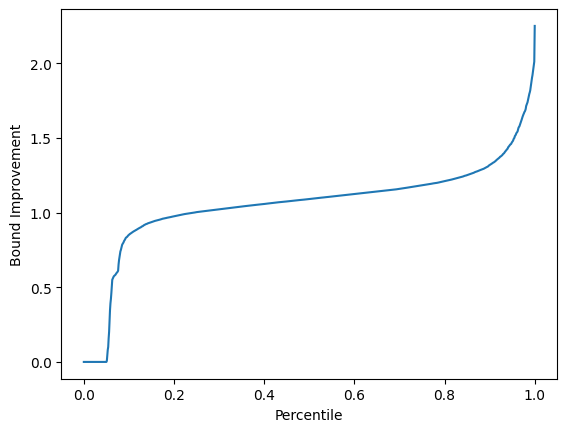

In [48]:
x = np.linspace(0,1,1000)
y = []
for i in x:
    y.append(np.percentile(bound_improvements, i*100))
print(y)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Percentile")
ax.set_ylabel("Bound Improvement")
plt.show()

# Summary

In [70]:
# Concat tables
table_1_full = pd.concat([table_1_full_epsilon, table_1_full_mnist_veriprune])
table_1_full[("solver","")] = [x[1] for x in table_1_full.index]
table_1_full[("property","")] = [x[0] for x in table_1_full.index]
table_1_prop_full = table_1_full[table_1_full[("property","")]=="Full"]
table_1_prop_focus = table_1_full[table_1_full[("property","")]=="Focus"]
table_1_full = pd.concat([table_1_prop_full, table_1_prop_focus])
table_1_full.index = table_1_full.index.droplevel(1)
print(table_1_full[[("benchmark",""),("solver",""),("safe","sum"),("unsafe","sum"),("speedup","median"),("speedup","max")]].to_latex(header=False, na_rep='---',float_format="%.1f"))

\begin{tabular}{lllrrrr}
\toprule
Full  &   ACAS &  MILPEquiv &   16 &    3 & 7224.8 & 36297.0 \\
Full  &   ACAS &    Marabou &  110 &  109 &  141.3 & 10070.5 \\
Full  &   ACAS &    NNEquiv &   37 &  142 &   37.3 &  8091.2 \\
Full  &   ACAS &   VeryDiff &  150 &  153 &    --- &     --- \\
Full  &   ACAS &    abCROWN &  121 &  150 &   15.4 &  1954.1 \\
Full  &  MNIST &  MILPEquiv &    7 &   28 &  525.2 &  1985.4 \\
Full  &  MNIST &    Marabou &   10 &   24 &  183.9 &  1390.8 \\
Full  &  MNIST &    NNEquiv &    0 &  103 &   12.6 &   166.2 \\
Full  &  MNIST &   VeryDiff &  352 &   62 &    --- &     --- \\
Full  &  MNIST &    abCROWN &  175 &  110 &  516.9 &  4220.8 \\
Focus &   ACAS &  NeuroDiff &  121 &   79 &   43.1 & 16134.7 \\
Focus &   ACAS &   VeryDiff &  169 &  161 &    --- &     --- \\
Focus &  MNIST &  NeuroDiff &  410 &   48 &    4.5 &  1086.8 \\
Focus &  MNIST &   VeryDiff &  457 &  242 &    --- &     --- \\
\bottomrule
\end{tabular}



/tmp/ipykernel_132989/2784364915.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_1_full[[("benchmark",""),("solver",""),("safe","sum"),("unsafe","sum"),("speedup","median"),("speedup","max")]].to_latex(header=False, na_rep='---',float_format="%.1f"))


In [37]:
def evaluate_cactus(comparison_times, tools, ax, print_legend=True,to=210,total=None,timeout_label_offset=50):
    #ax.set_yscale('log')
    if total is not None:
        ax.set_xlim([0,total])
    min_time = 1
    for (tool_name, color, marker) in tools:
        tool_times = comparison_times[~(comparison_times[eval_name+"-status"].isin(["error","unknown"]))][eval_name+"-time"]
        sorted_tool_times = np.sort(tool_times)
        yvals = np.arange(len(sorted_tool_times))
        min_time = min(min_time,sorted_tool_times[0])
        #sorted_tool_times = np.append(sorted_tool_times, to)
        #yvals = np.append(yvals, yvals[-1])
        ax.plot(yvals, sorted_tool_times, label=tool_name, color=color, marker=marker)
    if print_legend:
        ax.plot([0,total],[to,to],color="black")
        ax.text(20, to-timeout_label_offset, 'Timeout', fontsize=12, color="black")
        middle_pos = np.exp(np.log(min_time)+0.5*(np.log(to)-np.log(min_time)))
        ax.text(total-30, middle_pos, 'All Instances', fontsize=12, color="black",rotation=90,horizontalalignment="center",verticalalignment="center")
        ax.legend(loc='lower right') # bbox_to_anchor=(0.0,0.97)

In [38]:
def add_line(plt, df, solver):
    times = df.loc[(df["solver"] == solver) & (df["time"] <=120), "time"]
    times = np.sort(times)
    xvals = np.arange(len(times))
    plt.plot(xvals, times, label=solver)

In [39]:
results_all = pd.concat([results_full_acas, results_full_mnist])
print("Instances in ACAS+MNIST-Full:", len(results_all))
results_all = results_all[results_all["solver"]!="MILPEquiv"]
print("Instances without MILPEquiv:", len(results_all))
results_all = results_all[results_all["status"]!="unknown"]
print("Instances without unknown:", len(results_all))
print(results_all["solver"].unique())

Instances in ACAS+MNIST-Full: 3671
Instances without MILPEquiv: 3021
Instances without unknown: 1555
['NNEquiv' 'VeryDiff' 'abCROWN']


Text(0, 0.5, 'Time (s)')

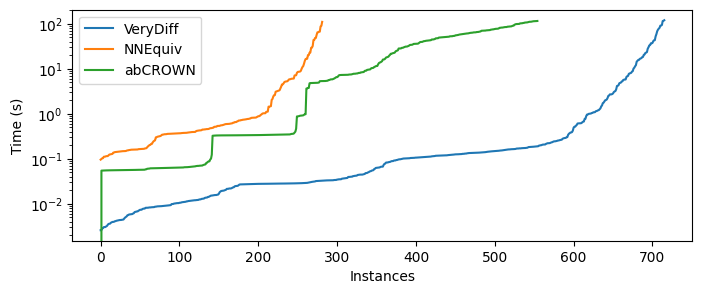

In [43]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_yscale('log')
add_line(ax, results_all, "VeryDiff")
add_line(ax, results_all, "NNEquiv")
add_line(ax, results_all, "abCROWN")
ax.legend(loc='upper left')
ax.set_xlabel("Instances")
ax.set_ylabel("Time (s)")